# 1. BUSINESS PROBLEM
---

## 1.1. Context

Our client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

An insurance policy is an arrangement by which a company undertakes to provide a guarantee of compensation for specified loss, damage, illness, or death in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarantee.

For example, you may pay a premium of Rs. 5000 each year for a health insurance cover of Rs. 200,000/- so that if, God forbid, you fall ill and need to be hospitalised in that year, the insurance provider company will bear the cost of hospitalisation etc. for upto Rs. 200,000. Now if you are wondering how can company bear such high hospitalisation cost when it charges a premium of only Rs. 5000/-, that is where the concept of probabilities comes in picture. For example, like you, there may be 100 customers who would be paying a premium of Rs. 5000 every year, but only a few of them (say 2-3) would get hospitalised that year and not everyone. This way everyone shares the risk of everyone else.

Just like medical insurance, there is vehicle insurance where every year customer needs to pay a premium of certain amount to insurance provider company so that in case of unfortunate accident by the vehicle, the insurance provider company will provide a compensation (called ‘sum assured’) to the customer.

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue. 

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

Problem description on Kaggle: [click here](https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction/data) to more information.

Note: the example has Rs. i.e. Rupee, an Indian money sign. So, the problem potentially is from an indian company.

## 1.2.Understanding the problem

### 1.2.1. Motivation

An Insurance company wants to cross sell the health insurance with vehicle insurance.

### 1.2.2. Root cause of the problem

Ensuring optimal coverage for both health and vehicle-related contingencies poses a unique challenge in cross-selling insurance products. Identifying clients willing to accept vehicle insurance alongside their health coverage while also remaining cognizant of potential health and vehicle-related issues is paramount.

The primary objective lies in attracting clients who not only find value in bundling these insurances but also contribute to the profitability of the portfolio.

### 1.2.3. Solution format

- Granularity and problem type: ID classification of interested or not
- Potential solution methods: logistic regression, tree based models, KNN;
- Delivery format:
    - Client prediction of interest on vehicle insurance;
    - Possibility of *google sheets* to check the clients information and customize the priorization, not just by rank of customer profit.

# 2. IMPORTS
---

## 2.1. Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

## 2.2. Helper functions

In [3]:
def plot_percentage_by_category(df, category_col, target_col):
    """
    Plots a bar plot showing the percentage of target = 1 by category, with bars representing 100% behind.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the data.
    category_col (str): Column name for the categories (y-axis).
    target_col (str): Column name for the target values (x-axis).
    """
    # Change the category_col to str
    df[category_col] = df[category_col].astype(str)


    # Calculate the percentage of target = 1 for each category
    percentages = df.groupby(category_col)[target_col].mean() * 100

    # Calculate total count and percentage for each category relative to entire dataset
    total_count = df.groupby(category_col)[target_col].count()
    total_percentage = (total_count / df.shape[0]) * 100

    # Sort categories by descending order of percentages
    percentages = percentages.sort_values(ascending=False)
    total_percentage = total_percentage.reindex(percentages.index)  # Reindex to match order

    # Plotting
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

    # Using Seaborn style and color palette
    sns.set_style("white")  # Remove grid and use white background

    # Light blue color for 100% bars
    color_100 = 'lightblue'

    # Single shade of blue for percentage bars
    color_percentage = 'steelblue'

    # Convert index to string for proper plotting
    categories = percentages.index.astype(str)

    # Plotting 100% bars
    bars_100 = plt.barh(categories, [100] * len(percentages), color=color_100, edgecolor='black')

    # Adding quantities and percentages on top of 100% bars
    for i, bar in enumerate(bars_100):
        category = categories[i]
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                 f'{total_count[category]} ({total_percentage[category]:.2f}%)',
                 va='center', ha='left', fontsize=10)

    # Plotting percentage bars
    bars = plt.barh(categories, percentages, color=color_percentage, edgecolor='black')

    # Adding percentages values inside the bars
    for bar in bars:
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}%',
                 va='center', ha='left', fontsize=10)

    # Removing spines (borders)
    sns.despine()

    # Adding labels and title
    plt.xlabel('Percentage (%)')
    plt.ylabel(category_col)
    plt.title(f'Percentage of {target_col} = 1 by {category_col}')

    # Show plot
    plt.show()

## 2.3. Loading data

I downloaded the dataset from Kaggle. However, to replicate a true operational environment, I uploaded the data to a specific server on Render and accessed it using SQL queries. 

All the process has been documented on "upload_and_get_data" folder and the official data have been stored on data/raw folder.


In [3]:
df = pd.read_csv('../data/raw/health_insurance_cross_sell.csv').sort_values('id')

# 3. DATA DESCRIPTION
---

|Variable|Definition|
|--------|----------|
|id|Unique ID for the customer|
|Gender|Gender of the customer|
|Age|Age of the customer|
|Driving_License|0 : Customer does not have DL, 1 : Customer already has DL|
|Region_Code|Unique code for the region of the customer|
|Previously_Insured|1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance|
|Vehicle_Age|Age of the Vehicle|
|Vehicle_Damage|1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.|
|Annual_Premium|The amount customer needs to pay as premium in the year|
|Policy_Sales_Channel|Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.|
|Vintage|Number of Days, Customer has been associated with the company|
|Response|1 : Customer is interested, 0 : Customer is not interested|

In [4]:
df.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
95113,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
444877,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
95114,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
381280,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
158524,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 3.1. Data dimension

In [5]:
print(f'Number of rows: {df.shape[0]};')
print(f'Number of columns: {df.shape[1]}.')

Number of rows: 508146;
Number of columns: 12.


## 3.2. Data types

In [6]:
df.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 3.3. Check NaN values

In [7]:
df.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 3.4. Descriptive statistics

Before we start, I want to separate the numerical and categorical variables, just because the analysis to these sets are different.

In [8]:
# Defining the numerical and categorical dfs
num_attributes = df[['age', 'annual_premium', 'vintage']]


cat_attributes = df[['gender', 'driving_license', 'region_code', 'previously_insured', 
                     'vehicle_age', 'vehicle_damage', 'policy_sales_channel', 'response']]

# Showing these dataframes
print('Numerical attributes:')
display(num_attributes)

print('Categorical attributes:')
display(cat_attributes)

Numerical attributes:


,age,annual_premium,vintage
95113,44,40454.0,217
444877,76,33536.0,183
95114,47,38294.0,27
381280,21,28619.0,203
158524,29,27496.0,39
...,...,...,...
190348,26,30867.0,56
413067,38,28700.0,165
444876,21,29802.0,74
476538,71,62875.0,265


Categorical attributes:


,gender,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,policy_sales_channel,response
95113,Male,1,28.0,0,> 2 Years,Yes,26.0,1
444877,Male,1,3.0,0,1-2 Year,No,26.0,0
95114,Male,1,28.0,0,> 2 Years,Yes,26.0,1
381280,Male,1,11.0,1,< 1 Year,No,152.0,0
158524,Female,1,41.0,1,< 1 Year,No,152.0,0
...,...,...,...,...,...,...,...,...
190348,Female,1,37.0,1,< 1 Year,No,152.0,0
413067,Female,1,28.0,0,1-2 Year,Yes,122.0,0
444876,Male,1,46.0,1,< 1 Year,No,152.0,0
476538,Male,1,28.0,1,1-2 Year,No,26.0,0


### 3.4.1. Numerical attributes

In [9]:
# Creating the metrics dataframe
metrics = num_attributes.describe().T

# Creating the skewness and kurtosis of each variables
skews = num_attributes.apply(lambda x: x.skew()).T
kurtosis = num_attributes.apply(lambda x: x.kurtosis()).T

# Creating the range of min and max values
metrics['range'] = metrics['max'] - metrics['min']

# Adding the skews and kurthosis values on metrics dataframe
metrics['skew'] = skews
metrics['kurtosis'] = kurtosis

# Changing the index to a variable and renaming it
metrics.reset_index(inplace=True)
metrics.rename({'index':'attribute'}, axis=1, inplace=True)

# Changing the order of columns apresentation on dataframe
metrics = metrics[['attribute', 'min', '25%', '50%', '75%', 'max', 'range', 'mean', 
                   'std', 'skew', 'kurtosis']]
display(metrics)

,attribute,min,25%,50%,75%,max,range,mean,std,skew,kurtosis
0,age,20.0,25.0,36.0,49.00,85.0,65.0,38.808413,15.500179,0.672751,-0.564665
1,annual_premium,2630.0,24381.0,31661.0,39403.75,540165.0,537535.0,30554.453041,17146.574625,1.600176,30.047860
2,vintage,10.0,82.0,154.0,227.00,299.0,289.0,154.340123,83.668793,0.002639,-1.200259


- There is a high kurtosis on `annual_premium`. So, the data is concentrated in a small range i.e. low dispersion
- Our max value is Rs. 540,165, maybe it is normal to India
- The `vintage` doesn't complete 1 year

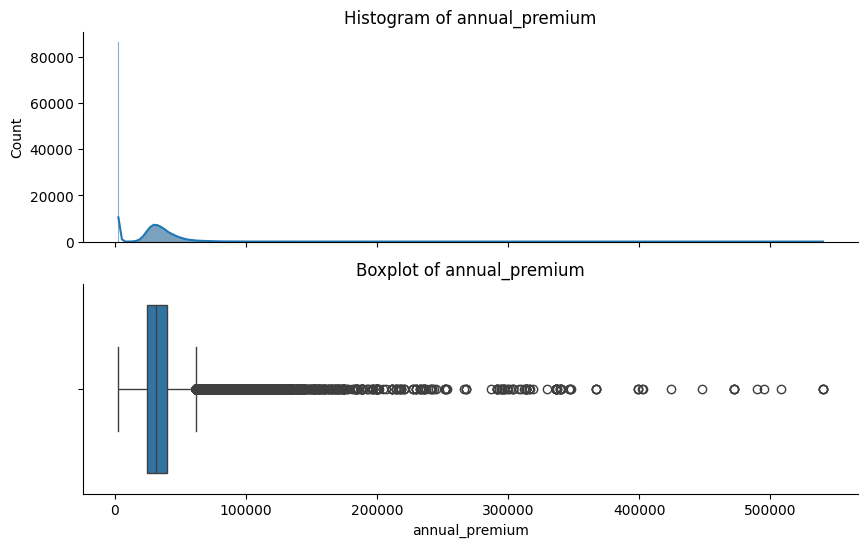

In [10]:
# Showing the annual_premium distribution
fig, axs = plt.subplots(2, sharex=True, figsize=(10, 6))
sns.histplot(data=df, x='annual_premium', ax=axs[0], kde=True)
axs[0].set_title('Histogram of annual_premium')

sns.boxplot(data=df, x='annual_premium', ax=axs[1])
axs[1].set_title('Boxplot of annual_premium')

sns.despine();

**MY FEELING**

There are a lot of data **next to zero** and a **high quantity of outliers**... we have to pay attention in this variable for the models. Some possible explanation of outliers:
- **High correlation with age or gender** and **quantity of people** relation. If there are a lot of young people or female gender in our data then make sense
- **Familiar health insurance**, making the `annual_premium` more expensive
- Input human error
- True value of health insurance

Note: female gender lives more compared to male, it's a statistic data.

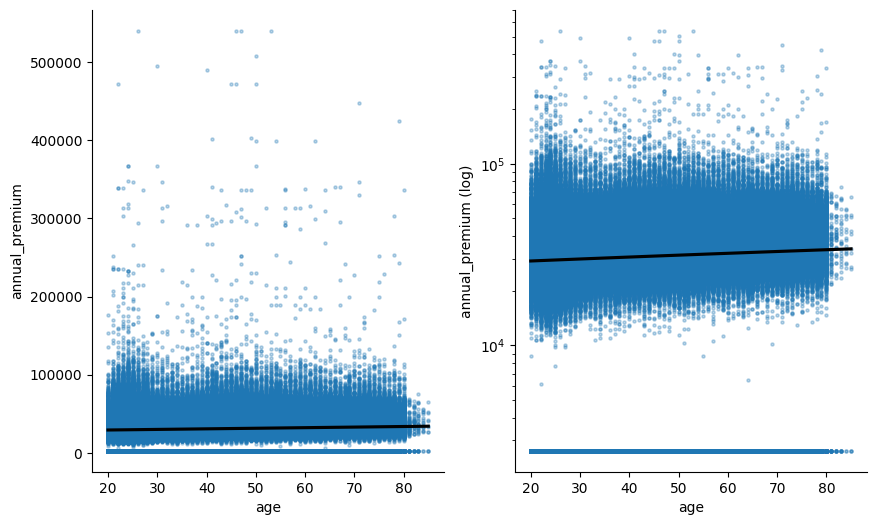

In [11]:
# Check the correlation of annual_premium and age
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
sns.regplot(data=df, x='age', y='annual_premium',
            scatter_kws={'s': 5, 'alpha': 0.3}, 
            line_kws={'color': 'black'}, ax=axs[0])

sns.regplot(data=df, x='age', y='annual_premium',
            scatter_kws={'s': 5, 'alpha': 0.3}, 
            line_kws={'color': 'black'}, ax=axs[1])
axs[1].set_ylabel('annual_premium (log)')
axs[1].set_yscale('log')

sns.despine();

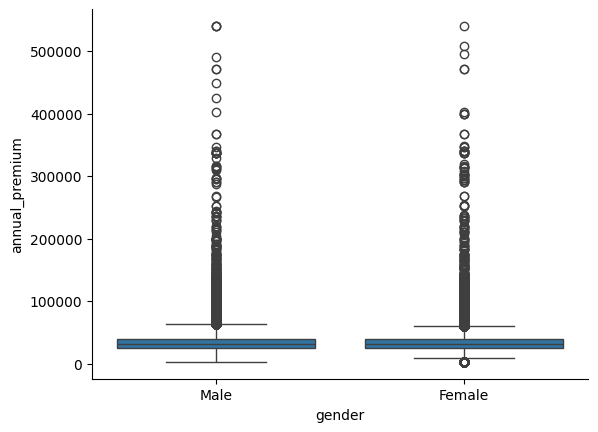

In [12]:
# Check annual_premium with gender
sns.boxplot(data=df, x='gender', y='annual_premium')
sns.despine();

From the figures, `annual_premium` has a low correlation with `age` and a low relationship with `gender`... maybe combining other features it generates another insight.

**SOME RESEARCH FROM ACKO HEALTH INSURANCE**

The webpage from Acko (indian health insurance company) provides comprehensive guidance on determining the appropriate amount of health insurance coverage for individuals and families. Here are the key points covered:

1. **Assessment Factors**: The amount of health insurance needed depends on several factors, including age, family size, lifestyle, medical history, and geographic location. Younger individuals and those with fewer dependents typically require less coverage compared to older individuals or those with larger families.

2. **Coverage Amount**: Acko suggests that the sum insured should ideally be at least half of one’s annual income. This ensures adequate coverage without overstretching finances. For families with elderly members or those with specific health needs, higher coverage plans are recommended, such as the ACKO Platinum Health Plan, which offers a higher sum insured and additional benefits like zero waiting periods and no claim deductions.

3. **Health Insurance Plans**: Acko offers various health insurance plans, including:
   - **ACKO Standard Health Plan**: Suitable for general needs with sums insured ranging from **Rs. 10 lakhs to Rs. 1 crore**, covering critical illnesses and pre and post-hospitalization expenses.
   - **ACKO Platinum Health Plan**: Designed for comprehensive coverage with options up to **Rs. 1 crore and unlimited sum insured**, zero co-payment, and multiple built-in add-ons.
   - **ACKO Platinum Super Top-up Plan**: Provides **high sum insured options** and covers critical illnesses, emergency evacuations, and multiple ambulance trips.

4. **Special Considerations**: For individuals with specific health needs or pre-existing conditions, plans like the ACKO Platinum Health Plan are ideal due to their extensive coverage and lack of waiting periods. Additionally, for families with elderly members, super top-up plans can provide additional security without requiring an additional primary insurance package.

5. **Government Schemes**: The Ayushman Bharat scheme (Pradhan Mantri Jan Arogya Yojana) provides free health care for economically weaker sections, offering coverage up to **Rs. 5 lakhs per family per year**, including pre and post-hospitalization expenses and pre-existing disease coverage.

Overall, the decision on the amount of health insurance to purchase should be based on a thorough evaluation of personal and family health needs, income levels, and potential future medical expenses. For detailed information, you can visit the Acko website directly at [Acko Health Insurance Guide](https://www.acko.com/health-insurance/deciding-how-much-health-insurance-you-need/).

Note: A crore (cr) denotes ten million and is equal to 100 lakh in the Indian numbering system. So 1 lakh is 100,000 rupees.

So, the values from this variable is normal to ACKO!

### 3.4.1. Categorical attributes

In [13]:
# Getting the categorical description
for cat in cat_attributes.columns:
    count = pd.DataFrame(cat_attributes[cat].value_counts())
    prop = pd.DataFrame(cat_attributes[cat].value_counts(normalize=True))
    
    grouped_info = count.join(prop)
    display(round(grouped_info, 3))

,count,proportion
gender,,
Male,274325,0.54
Female,233821,0.46


,count,proportion
driving_license,,
1,507097,0.998
0,1049,0.002


,count,proportion
region_code,,
28.0,141937,0.279
8.0,44900,0.088
46.0,26357,0.052
41.0,24400,0.048
15.0,17750,0.035
30.0,16276,0.032
29.0,14843,0.029
50.0,13657,0.027
3.0,12349,0.024


,count,proportion
previously_insured,,
0,275076,0.541
1,233070,0.459


,count,proportion
vehicle_age,,
1-2 Year,267015,0.525
< 1 Year,219805,0.433
> 2 Years,21326,0.042


,count,proportion
vehicle_damage,,
Yes,256248,0.504
No,251898,0.496


,count,proportion
policy_sales_channel,,
152.0,179523,0.353
26.0,106594,0.210
124.0,98299,0.193
160.0,29090,0.057
156.0,14313,0.028
...,...,...
143.0,1,0.000
84.0,1,0.000
41.0,1,0.000


,count,proportion
response,,
0,461436,0.908
1,46710,0.092


**NOTES**

- There are a lot of distinct `region_code`s and `policy_sales_channel`, so we can simplify these information
- We are working with **imbalanced data**, we have just **10% of interest on vehicle insurance**

**IMPORTANT QUESTION**

If someone doesn't have driving license, is he interested on vehicle insurance?

In [14]:
# Verification of driving license
pd.DataFrame(df.groupby(['driving_license', 'response'])['id'].count())

id
driving_license response        
0               0           1008
                1             41
1               0         460428
                1          46669

If someone doesn't have driving license, then probably he won't be interested on vehicle insurance, and if he is interested, it's because he is going to buy a car and will get the license soon.

Like we saw above, the quantity of responses equal to 1 when `driving_license` is 0 is so low. Thus I will drop the people that don't have driving license from our data and I won't include in the future models.

# 4. DATA PREPARATION
---

Maybe we can create some variables from:
- `region_code`: `famous_region` i.e. most famous region code or not (28)
- `vehicle_age`: `vehicle_age2` i.e. "< 1 Year" and ">= 1 Year"
- `policy_sales_channel`: `famous_policy_sales_channel` i.e. most famous policy sales channels or not (152, 26 and 124)
- `annual_premium` / `vintage`: `hi_customer_profitability` i.e. health insurance customer by used days, giving an idea of customer actual profit for the company

The main purpose is just to simplify or improve our future models.

## 4.1. Mind map hypothesis

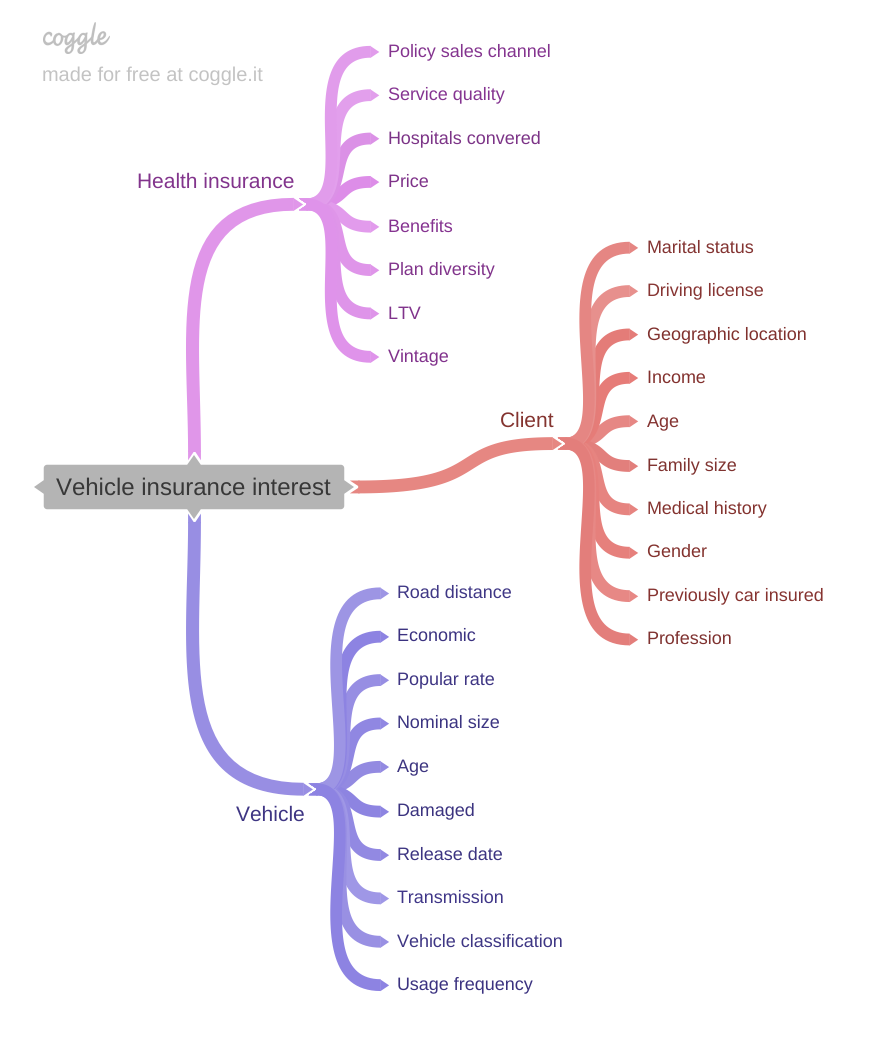

In [15]:
# Business mindmap
Image('../img/mind_map_hypothesis.png')

## 4.2. Creating hypothesis

### 4.2.1. Health insurance hypothesis

**1.** Different policy sales channel of health insurance doesn't change the vehicle insurance interest

**2.** High service quality of health insurance is essencial to make a conversion on vehicle insurance

**3.** The more hospitals included in health insurance, the greater the interest on vehicle insurance

**4.** The higher annual premium price on health insurance, the lower the interest on vehicle insurance

**5.** The more benefits included on health insurance, the greater the interest on vehicle insurance

**6.** The more diversity of health insurance plans, the greater the interest on vehicle insurance

**7.** The higher the customer's LTV on health insurance, the greater the interest in vehicle insurance

**8.** The higher vintage on health insurance, the greater the interest in vehicle insurance

### 4.2.2. Client hypothesis

**1.** Married customers have more interest on vehicle insurance

**2.** Customers living on famous regions are more interested on vehicle insurance

**3.** The higher income of customers, the greater the interest on vehicle insurance

**4.** Older customers have more interest on vehicle insurance

**5.** The greater the family size of customer, the greater the interest in vehicle insurance

**6.** Bad medical history makes more interest on vehicle insurance

**7.** There is a difference between genders when comparing the vehicle insurance interest

**8.** If the car has been insured, then the customers will have more interest on the insurance of the company

**9.** Some of professions have more interest on vehicle insurance

### 4.2.3. Vehicle hypothesis

**1.** The lower road distance, the greater the interest on vehicle insurance
 
**2.** If the vehicle is economic, then the vehicle insurance interest is greater 

**3.** The higher popular rate of the vehicle, the greater the interest on vehicle insurance

**4.** The higher nominal size, the greater the interest on vehicle insurance

**5.** Customers with older vehicle have less interest on vehicle insurance

**6.** If the vehicle was been damaged, then the vehicle insurance interest is greater

**7.** The older realese date of the vehicle, the lower the interest on vehicle insurance

**8.** If the vehicle is automatic, then the vehicle insurance interest is greater

**9.** THe higher vehicle classification, the greater the interest on vehicle insurance

**10.** If the frequency of use of the vehicle is high, then the vehicle insurance interest is greater

## 4.3. Final hypothesis list

The criterion used here is if we have the data to answer the hypothesis. On the other hand, if we don't have them, we could ask for another sector of the company to get the new data.

Basically, we analyse the data that we have now.

**1.** Different policy sales channel of health insurance doesn't change the vehicle insurance interest

**2.** The higher annual premium price on health insurance, the lower the interest on vehicle insurance

**3.** The higher vintage on health insurance, the greater the interest in vehicle insurance

**4.** Customers living on famous regions are more interested on vehicle insurance

**5.** Older customers have more interest on vehicle insurance

**6.** Bad medical history makes more interest on vehicle insurance

**7.** There is a difference between genders when comparing the vehicle insurance interest

**8.** If the car has been insured, then the customers will have more interest on the insurance of the company

**9.** Customers with older vehicle have less interest on vehicle insurance

**10.** If the vehicle was been damaged, then the vehicle insurance interest is greater

**11.** Customers more profitable are more interested on vehicle insurance

## 4.4. Creating features

In [16]:
# Famous region
df['famous_region'] = 0
df.loc[df['region_code'] == 28, 'famous_region'] = 1

In [17]:
# Vehicle age 2
df['vehicle_age2'] = 0
df.loc[df['vehicle_age'].isin(['1-2 Year', '> 2 Years']), 'vehicle_age2'] = 1

In [18]:
# Famous policy sales channel
df['famous_policy_sales_channel'] = 0
df.loc[df['policy_sales_channel'].isin([152, 26, 124]), 'famous_policy_sales_channel'] = 1

In [19]:
# Health insurance customer profitability
df['hi_customer_profitability'] = df['annual_premium'].div(df['vintage']).fillna(0)

# 5. VARIABLES FILTERING
---

Like I've said, I'm going to filter out who doesn't have driving license.

In [20]:
# Filter who doesn't have driving license
df = df[df['driving_license'] == 1].drop('driving_license', axis=1)

In [21]:
# Saving the data for EDA section
df.to_csv('../data/preprocessed/hi_cs_preprocessed.csv', index=False)

# 6. EXPLORATORY DATA ANALYSIS (EDA)
---

In [4]:
# Importing the data
df_eda = pd.read_csv('../data/preprocessed/hi_cs_preprocessed.csv')

## 6.1. Univariate analysis

### 6.1.1. Response variable

In [23]:
count = pd.DataFrame(df_eda['response'].value_counts())
prop = pd.DataFrame(df_eda['response'].value_counts(normalize=True))

grouped_info = count.join(prop)
display(round(grouped_info, 3))

,count,proportion
response,,
0,460428,0.908
1,46669,0.092


Like I already said, we are working with imbalanced data. We have to use models that fit well with this kind of problems.

### 6.1.2. Numerical variables

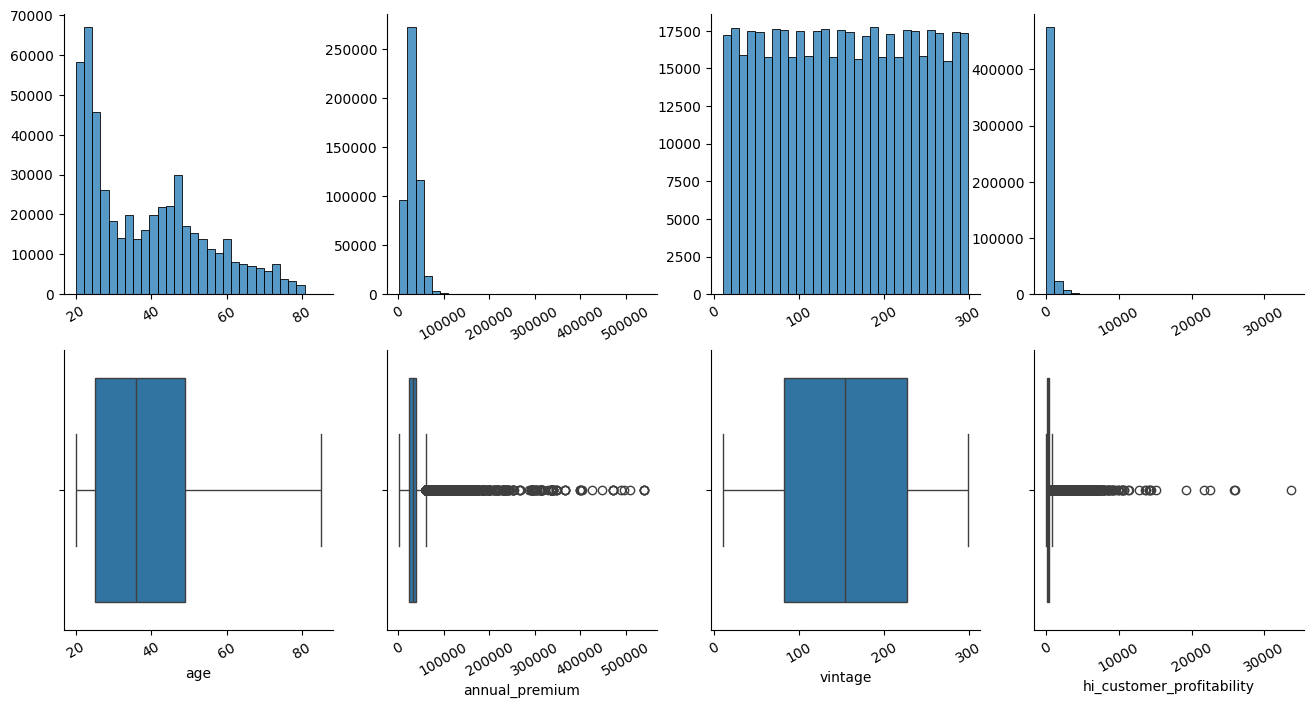

In [24]:
# Plotting all the histograms and boxplots
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

num_vars = ['age', 'annual_premium', 'vintage', 'hi_customer_profitability']

for i, var in enumerate(num_vars):
    sns.histplot(x=var, data=df_eda, ax=axes[i], bins=30)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for i, var in enumerate(num_vars):
    sns.boxplot(x=var, data=df_eda, ax=axes[i+4])

for ax in axes:
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)

sns.despine();

- `age` has a right tail in distribution and the mode is between 20 and 25 years old
- `vintage` has a symmetric distribution, close to the uniform

### 6.1.3. Categorical variables

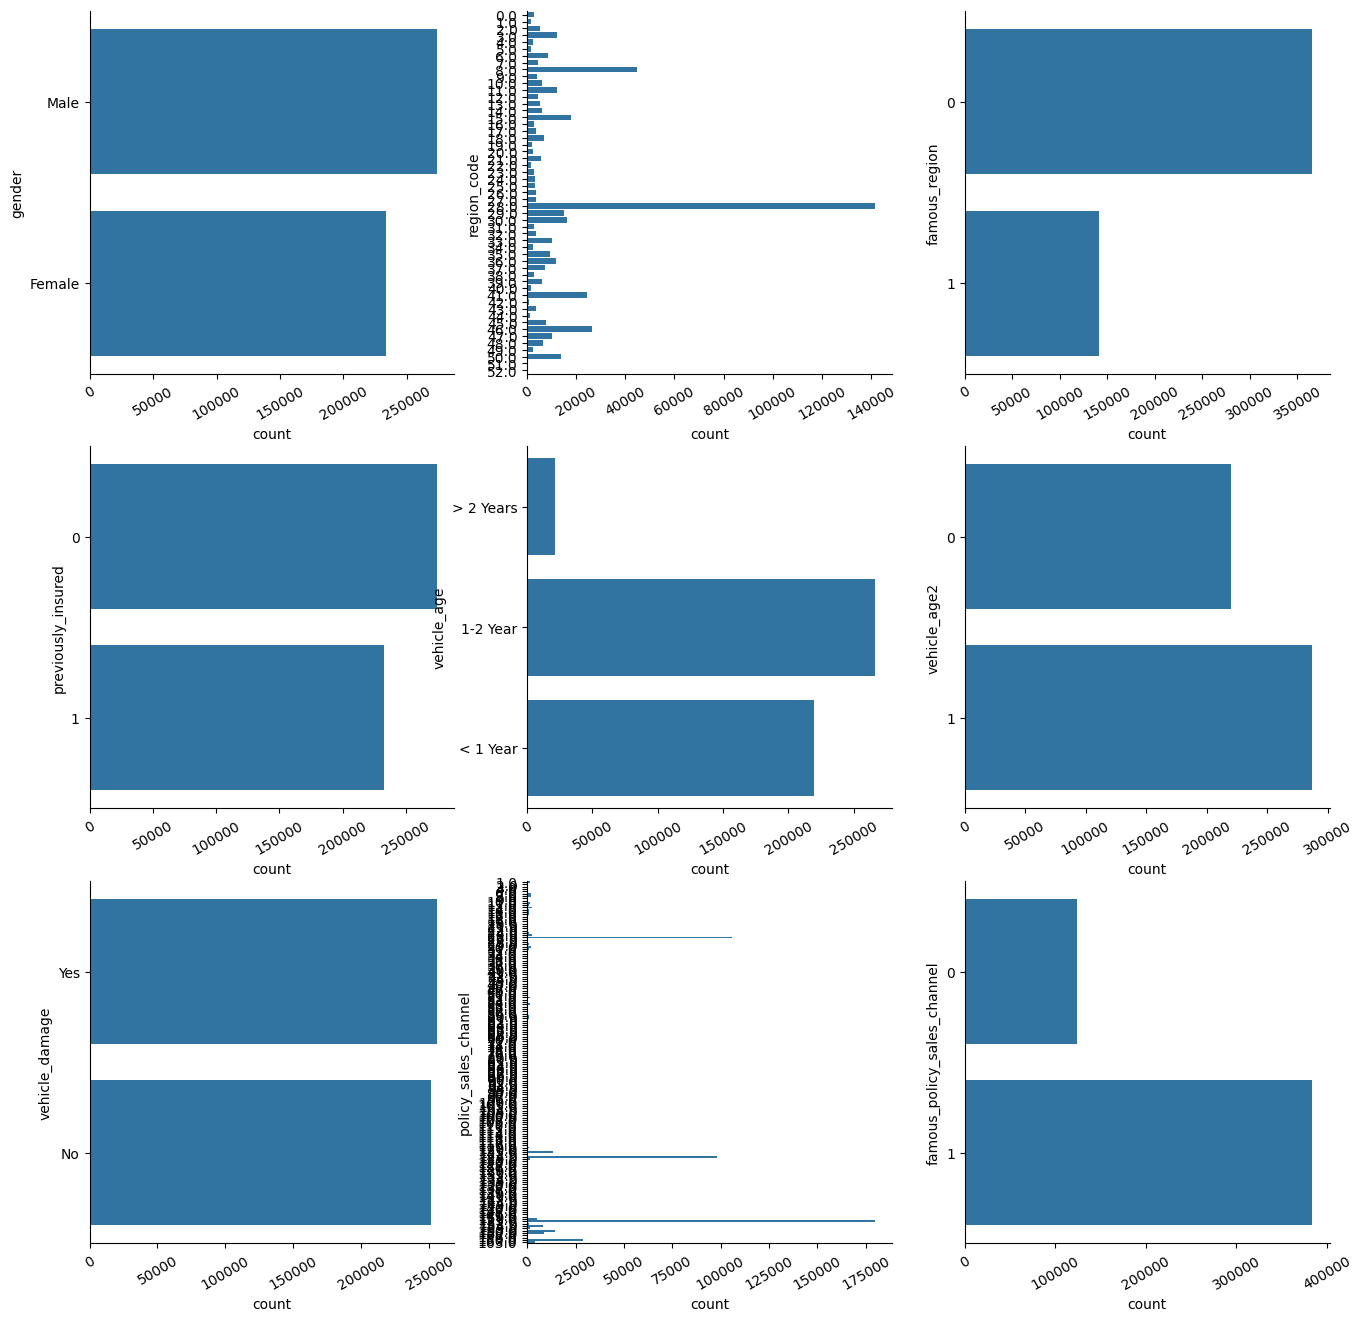

In [25]:
# Plotting the countplots
fig, axes = plt.subplots(3, 3, figsize=(16, 16))
axes = axes.flatten()

sns.countplot(y='gender', data=df_eda, ax=axes[0])
sns.countplot(y='region_code', data=df_eda, ax=axes[1])
sns.countplot(y='famous_region', data=df_eda, ax=axes[2])
sns.countplot(y='previously_insured', data=df_eda, ax=axes[3])
sns.countplot(y='vehicle_age', data=df_eda, ax=axes[4])
sns.countplot(y='vehicle_age2', data=df_eda, ax=axes[5])
sns.countplot(y='vehicle_damage', data=df_eda, ax=axes[6])
sns.countplot(y='policy_sales_channel', data=df_eda, ax=axes[7])
sns.countplot(y='famous_policy_sales_channel', data=df_eda, ax=axes[8])

for ax in axes:
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)

sns.despine();

- There are a lot of distinct items on `region_code` and `policy_sales_channel`. These are flags to drop these variables from data
- The `famous_policy_channel` = 1 has the largest amount of data
- There is a low quantity of `vehicle_age` > 2 years, so adding this classification to >= 1 year, maybe it's a good idea


## 6.2. Bivariate analysis

### 6.2.1. $H_{1}$: Different policy sales channel of health insurance doesn't change the vehicle insurance interest

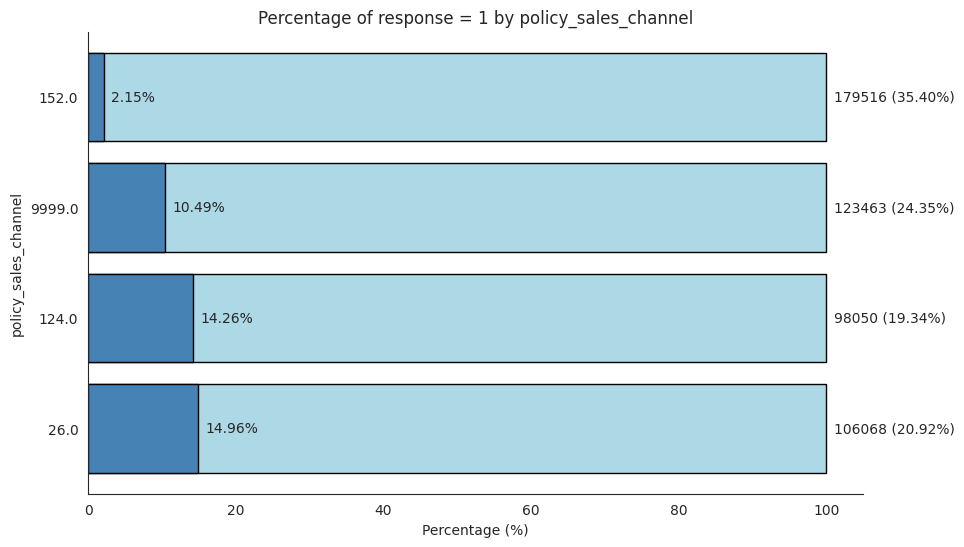

In [5]:
# Plotting the response by top 3 popular policy_sales_channel
top_three_pc = list(df_eda['policy_sales_channel']\
            .value_counts()\
            .reset_index()\
            .head(3)['policy_sales_channel'])

df_eda.loc[~df_eda['policy_sales_channel'].isin(top_three_pc), 'policy_sales_channel'] = 9999

plot_percentage_by_category(df_eda, 'policy_sales_channel', 'response')

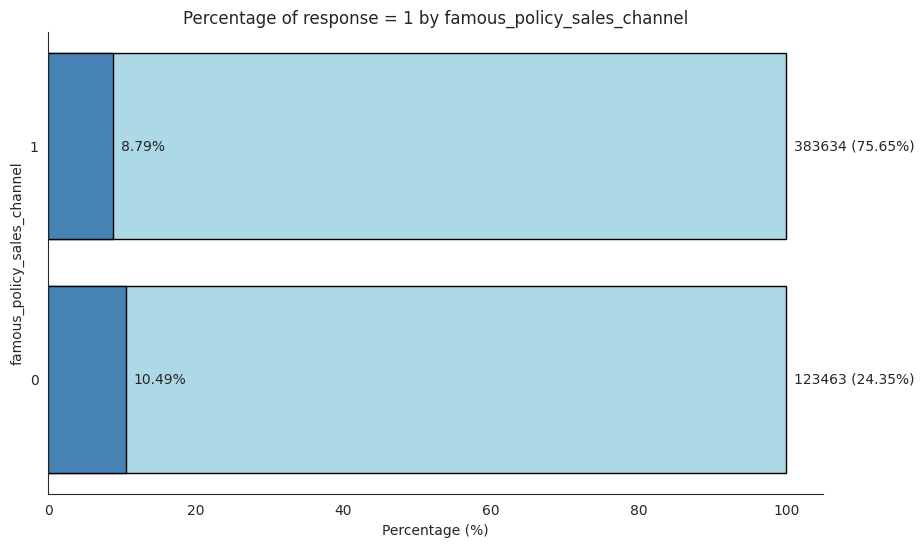

In [99]:
# Famous policy_sales_channel
plot_percentage_by_category(df_eda, 'famous_policy_sales_channel', 'response')

We can observe that **different policy sales channels have different percentage of responses**. Maybe I'll use the **top three divison** for modelling, because the classes have **near quantities** and the percentage of responses = 1 in code 152 is a little different compared between other codes.

### 6.2.2. $H_{2}$: The higher annual premium price on health insurance, the lower the interest on vehicle insurance

### 6.2.3. $H_{3}$: The higher vintage on health insurance, the greater the interest in vehicle insurance

### 6.2.4. $H_{4}$: Customers living on famous regions are more interested on vehicle insurance

### 6.2.5. $H_{5}$: Older customers have more interest on vehicle insurance

### 6.2.6. $H_{6}$: Bad medical history makes more interest on vehicle insurance

### 6.2.7. $H_{7}$: There is a difference between genders when comparing the vehicle insurance interest

### 6.2.8. $H_{8}$: If the car has been insured, then the customers will have more interest on the insurance of the company

### 6.2.9. $H_{9}$: Customers with older vehicle have less interest on vehicle insurance

### 6.2.10. $H_{10}$: If the vehicle was been damaged, then the vehicle insurance interest is greater

### 6.2.11. $H_{11}$: Customers more profitable are more interested on vehicle insurance